# MPBP and voter model

In [1]:
using MatrixProductBP
using MatrixProductBP.Models
using Graphs, IndexedGraphs, Random
using Plots, LaTeXStrings
using Statistics

In [2]:
Plots.default(
    grid = :off, box = :on,
    widen = true,
    label = "",
    lw = 1.5,
    msc = :auto,
    size = (400,300),
    markersize = 3,
    margin=5Plots.mm
)

## 1. Voter model with reweighted trajectories: check that MPBP agrees with montecarlo

In [3]:
function infer_voter(bp, p0; 
        rng = Random.default_rng(), svd_trunc = TruncThresh(5e-3),
        softinf=Inf)
    N = nv(bp.g)
    reset!(bp, observations=true)
    for i in 1:N
        bp.ϕ[i][1] .= [p0, 1-p0]
    end
    X = draw_node_observations!(bp, N; rng, last_time=true, softinf)
    svd_trunc = TruncThresh(5e-3)
    cb = CB_BP(bp; showprogress=false)
    iterate!(bp; maxiter=20, svd_trunc, cb, tol=1e-6, damp=0.6)
    bp, X, cb
end

infer_voter (generic function with 1 method)

In [35]:
rng = MersenneTwister(111)

T = 10
N = 5
p0 = 0.75
gg = prufer_decode(rand(rng, 1:N, N-2))
J = 1
w = fill(fill(HomogeneousVoterFactor(J), T+1), N)

bp = mpbp(IndexedBiDiGraph(gg), w, fill(2,N), T);

In [48]:
svd_trunc = TruncThresh(5e-4)
bp_, X, cb = infer_voter(bp, p0; svd_trunc, softinf=50);

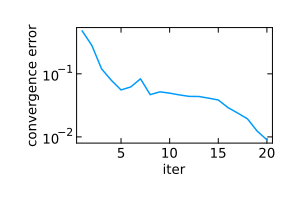

In [49]:
plot(filter(!isequal(0), cb.Δs), ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [50]:
sms = SoftMarginSampler(bp)
nsamples_mc = 10^5
sample!(sms, nsamples_mc; showprogress=false);

In [51]:
f(x, i) = 3-2x
m_mc = means(f, sms)
m_bp = means(f, bp);

Marginals from Soft Margin  40%|██████████               |  ETA: 0:00:00

Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:00


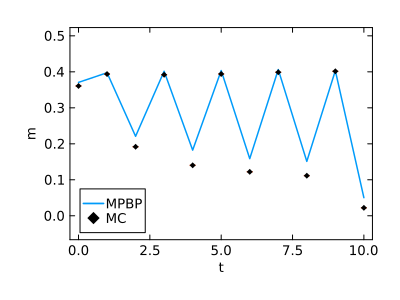

In [52]:
pl = plot(xlabel="t", ylabel="m", size=(400,300), grid=false)
plot!(pl, 0:T, mean(m_bp), label="MPBP", ylims=extrema(mean(m_bp)).+0.1.*(-1,1))
scatter!(pl, 0:T, mean(m_mc), label="MC", m=:diamond, c=:black)

## 2. Ability of MPBP to reconstruct the history of a voter dynamics from a snapshot at final time

In [53]:
using Unzip, ProgressMeter
nsamples = 10
bps, Xs, cbs = map(1:nsamples) do s
    bp_, X, cb = infer_voter(deepcopy(bp), p0; rng, svd_trunc)
    println("Finished sample $s of $(nsamples)")
    bp_, X, cb
end |> unzip;

Finished sample 1 of 10


Finished sample 2 of 10


Finished sample 3 of 10


Finished sample 4 of 10


Finished sample 5 of 10


Finished sample 6 of 10


Finished sample 7 of 10


Finished sample 8 of 10


Finished sample 9 of 10


Finished sample 10 of 10


In [54]:
Δts = 0:T

props = map(zip(bps,Xs)) do (bp,X)
    b_bp = beliefs(bp)
    prop = map(Δts) do Δt
        x_t = X[1][:,end-Δt]
        p_bp_t = [p[end-Δt] for p in b_bp]        
        mean(argmax(p)==x for (p,x) in zip(p_bp_t, x_t))
    end
end;

In [61]:
props_naive = map(zip(bps,Xs)) do (bp,X)
    b_bp = beliefs(bp)
    prop = map(Δts) do Δt
        x_t = X[1][:,end-Δt]
        y = X[1][:,end]     
        mean(yy==x for (yy,x) in zip(y, x_t))
    end
end;

In [62]:
using TensorTrains
maxbonddim(bp::MPBP) = maximum(maximum.(bond_dims.(bp.μ)))
av_bp = round(Int, mean(maxbonddim.(bps)));

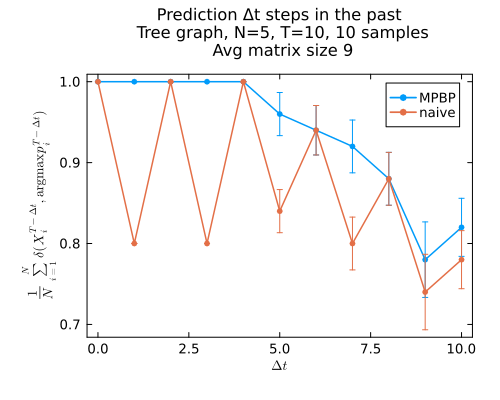

In [65]:
pl = plot(Δts, mean(props), yerr=std(props)./sqrt(nsamples),
    m=:o, xlabel=L"\Delta t", size=(500,400), label="MPBP",
    ylabel=L"\frac{1}{N}\sum_{i=1}^N \delta(X_i^{T-\Delta t}, \arg\max p_i^{T-\Delta t})",
    title="Prediction Δt steps in the past\n Tree graph, N=$N, T=$T, $nsamples samples\n Avg matrix size $av_bp")

plot!(pl, Δts, mean(props_naive), yerr=std(props)./sqrt(nsamples),
    m=:o, label="naive")